In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kkbox-music-recommendation-challenge/test.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/train.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/songs.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/members.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z
/kaggle/input/kkbox-music-recommendation-challenge/sample_submission.csv.7z


In [33]:
import pandas as pd
import numpy as np
import string
import math

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [34]:
#Unzip all data
!7z e "../input/kkbox-music-recommendation-challenge/members.csv.7z"
!7z e "../input/kkbox-music-recommendation-challenge/songs.csv.7z"
!7z e "../input/kkbox-music-recommendation-challenge/test.csv.7z"
!7z e "../input/kkbox-music-recommendation-challenge/train.csv.7z"
!7z e "../input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/kkbox-music-recommendation-challeng                                                      1 file, 1349856 bytes (1319 KiB)

Extracting archive: ../input/kkbox-music-recommendation-challenge/members.csv.7z
--
Path = ../input/kkbox-music-recommendation-challenge/members.csv.7z
Type = 7z
Physical Size = 1349856
Headers Size = 130
Method = LZMA2:3m
Solid = -
Blocks = 1

    
Would you like to replace the existing file:
  Path:     ./members.csv
  Size:     2503827 bytes (2446 KiB)
  Modified: 2017-09-22 00:09:55
with the file from archive:
  Path:     members.csv
  Size:     2503827 bytes (2446 KiB)
  Modified: 2017-09-22 00:09:55
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? ^C
(Y)es / (N)o / (A)lways / (S)kip all / A(u)to re

UnboundLocalError: local variable 'child' referenced before assignment

In [35]:
#Read data
song_data = pd.read_csv("./songs.csv")
song_extra_data = pd.read_csv("./song_extra_info.csv")
member_data = pd.read_csv("./members.csv")
train_data = pd.read_csv("./train.csv", nrows = 100000)
test_data=pd.read_csv("./test.csv")                   

In [36]:
#Merge datasets for ease of use
Merge1 = pd.merge(train_data, song_data, on='song_id', how='left')
Merge2= pd.merge(Merge1, song_extra_data, on='song_id', how='left')
songs = pd.merge(Merge2, member_data, on='msno', how='left')
del song_data, song_extra_data, member_data, train_data, Merge1,Merge2

In [ ]:
songs.head()

In [37]:
#see if we have null values
songs.isnull().values.any()

True

In [38]:
#seeing how many null values are present
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

In [39]:
#removing all null data will be best and the data set is still very large
songs.dropna(inplace=True)

In [40]:
songs.shape

(31737, 20)

In [41]:
#From songs.info we can see that bpth registration and expiration time are integers we need them in date time
songs['registration_init_time']=pd.to_datetime(songs['registration_init_time'])
songs['expiration_date']=pd.to_datetime(songs['expiration_date'])
songs.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31737 entries, 6 to 99987
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    31737 non-null  object        
 1   song_id                 31737 non-null  object        
 2   source_system_tab       31737 non-null  object        
 3   source_screen_name      31737 non-null  object        
 4   source_type             31737 non-null  object        
 5   target                  31737 non-null  int64         
 6   song_length             31737 non-null  float64       
 7   genre_ids               31737 non-null  object        
 8   artist_name             31737 non-null  object        
 9   composer                31737 non-null  object        
 10  lyricist                31737 non-null  object        
 11  language                31737 non-null  float64       
 12  name                    31737 non-null  object

In [42]:
#Encoding the dataset so all equal values have an equal number whch is required for machine learning
label_encoding = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoding.fit_transform(songs[i])
    
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
6,1815,4063,3,7,4,1,1756,50,79,2036,1878,5,5717,3412,11,13,0,3,842,218
11,3001,1225,3,7,3,1,1550,50,976,2634,2504,1,6347,5671,13,15,1,3,965,381
19,3009,1434,3,7,3,1,2189,50,1004,1389,2027,1,6629,3191,7,16,0,3,1356,219
21,3009,2289,3,7,3,1,2404,50,1346,1952,2900,1,4329,2792,7,16,0,3,1356,219
32,1621,571,3,7,3,1,1029,9,1383,2992,2926,1,3177,5198,11,23,1,3,654,219


In [43]:
X = songs.drop('target', axis = 1)
y = songs.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [48]:
def modeller(name, X_train, X_val, y_train, y_val) :
    print("ooooooooooooooooooooooooooooooooooooooooooooooo")
    print("Model in use :", name)
    print()
        
    if name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1200, 
        )
    elif name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1200, 
        )
    elif name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1200, 
        )
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))
    
    print("ooooooooooooooooooooooooooooooooooooooooooooooo")
    print()

In [49]:
models_to_use = ["Random Forest Classifier", "Extra Trees Classifier", "XGBoost Classifier"]
for i in models_to_use :
    modeller(i, X_train, X_val, y_train, y_val)

ooooooooooooooooooooooooooooooooooooooooooooooo
Model in use : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.73      0.40      0.51      1414
           1       0.85      0.96      0.90      4934

    accuracy                           0.83      6348
   macro avg       0.79      0.68      0.71      6348
weighted avg       0.82      0.83      0.81      6348


Accuracy : 0.832703213610586
ROC : 0.6774461075732914
ooooooooooooooooooooooooooooooooooooooooooooooo

ooooooooooooooooooooooooooooooooooooooooooooooo
Model in use : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.72      0.43      0.53      1414
           1       0.85      0.95      0.90      4934

    accuracy                           0.83      6348
   macro avg       0.78      0.69      0.72      6348
weighted avg       0.82      0.83      0.82      6348


Accuracy : 0.834593572778828
ROC : 0.6890051938774282
ooooooooooo

In [68]:
final_model=xgb.XGBClassifier(n_estimators=1300,learning_rate=0.08,max_depth=7,gamma=5,subsample=0.9)
final_model.fit(X_train, y_train)
predictions = final_model.predict(X_val)
print("Accuracy :", accuracy_score(y_val, predictions))


Accuracy : 0.8396345305608065


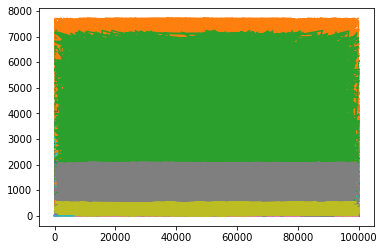